Now that you've learned how to build CNN architectures and fine-tune them, let's learn more about how to evaluate their performance over training epochs. This is important in helping us know if our model is learning, and when to stop training.

We'll continue building off of the previous exercises, with the image augmentation code and one model architecture already written for you in the notebook below. Your job in this exercise is to build a function that will plot the training history to look at how:

Training loss
Validation loss
Training accuracy
Validation accuracy Change over the course of your training epochs.
Once you build this function, change the parameters of your model (learning rate and amount of dropout) to see how your model performance curves differ with different parameters.

In [26]:
# Importing Required Libraries for Deep Learning and Data Processing
# 
# - numpy: Fundamental package for numerical computations in Python.
# - pandas: Data analysis and manipulation tool, used here for reading CSV files and handling dataframes.
# - os, glob: Utilities for interacting with the operating system and file paths.
# - matplotlib.pyplot: For plotting and visualizing data and training history.
# - tensorflow: Core deep learning framework.
# - skimage.io: For reading images from disk.
# - keras.preprocessing.image.ImageDataGenerator: For real-time data augmentation and preprocessing of images.
# - keras.layers: Provides neural network layers like Dense, Dropout, Flatten, Conv2D, MaxPooling2D, etc.
# - keras.models: For building sequential and functional models.
# - keras.applications: Pre-trained models (VGG16, ResNet50) for transfer learning.
# - keras.optimizers.Adam: Optimizer for training neural networks.
# - keras.callbacks: Utilities for model checkpointing, learning rate scheduling, early stopping, and reducing learning rate on plateau.

import tensorflow as tf
tf.config.run_functions_eagerly(True)

# Verify eager execution is enabled
print("Eager execution:", tf.executing_eagerly())


import numpy as np 
import pandas as pd 
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
from skimage import io

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import numpy as np 
import pandas as pd 
import os
from glob import glob

Eager execution: True


In [ ]:
# Loading Training and Validation DataFrames with pandas
# 
# - pandas is a powerful Python library for data manipulation and analysis.
# - pd.read_csv() reads a comma-separated values (CSV) file into a DataFrame.
# - Here, we load 'train.csv' into train_df and 'test.csv' into valid_df, which will be used for training and validating our model.

#

train_df = pd.read_csv('train.csv')
valid_df = pd.read_csv('test.csv')

## Setting up the image augmentation from last Lesson: 

In [4]:
# Setting the Image Size for Model Input
#
# - The variable IMG_SIZE defines the target size for input images to the neural network.
# - This is required by Keras' ImageDataGenerator and model architectures like VGG16, which expect images of a specific shape.
# - Setting IMG_SIZE = (224, 224) ensures all images are resized to 224x224 pixels before being fed into the model.

#

IMG_SIZE = (224, 224)

In [ ]:
# Image Augmentation and Data Generator Setup with Keras
#
# This block uses Keras' ImageDataGenerator to preprocess and augment image data for deep learning.
# - ImageDataGenerator: Provides real-time data augmentation (random transformations) and normalization for images.
# - flow_from_dataframe: Loads images and labels from a pandas DataFrame, allowing flexible data input.
# 
# For training data, we apply augmentation (flips, shifts, rotations, shear, zoom) to improve model generalization.
# For validation data, only rescaling is applied to ensure evaluation on unmodified images.
#
# Variable explanations:
# - IMG_SIZE: Tuple specifying the target size (height, width) for input images, here (224, 224).
# - train_df: DataFrame containing file paths and class labels for training images.
# - valid_df: DataFrame containing file paths and class labels for validation images.
# - train_idg: ImageDataGenerator instance for training data, which generates batches containing both original and randomly augmented images (each epoch, images are augmented on the fly).
# - val_idg: ImageDataGenerator instance for validation data, which generates batches containing only the original images with rescaling (no augmentation is applied).
# - train_gen: DataFrameIterator that yields batches of augmented training images and labels.
# - val_gen: DataFrameIterator that yields batches of rescaled validation images and labels.

train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 9
                                         )

# Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
val_idg = ImageDataGenerator(rescale=1. / 255.0
                                 )

val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                         directory=None, 
                                         x_col = 'img_path',
                                         y_col = 'class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 6) ## We've only been provided with 6 validation images

Found 20 validated image filenames belonging to 2 classes.
Found 6 validated image filenames belonging to 2 classes.


In [ ]:
# Pulling a Batch of Validation Data Using Keras ImageDataGenerator
#
# - Keras' ImageDataGenerator provides an efficient way to load and preprocess images in batches.
# - The DataFrameIterator (val_gen) yields batches of images and labels from a pandas DataFrame.
# - The `next()` function retrieves the next batch from the iterator, returning a tuple (images, labels).
# - Here, we use `next(val_gen)` to pull a single batch of validation data (testX, testY) for model evaluation after each epoch.
#
## Pull a single large batch of random validation data for testing after each epoch
testX, testY = next(val_gen)  

## Now we'll load in VGG16 with pre-trained ImageNet weights: 

In [ ]:
# Loading the VGG16 Model with Pre-trained ImageNet Weights
#
# - VGG16 is a popular deep convolutional neural network architecture, available in Keras via keras.applications.vgg16.
# - The VGG16() function loads the model architecture and, with weights='imagenet', loads pre-trained weights from the ImageNet dataset.
# - Setting include_top=True loads the fully connected layers at the top of the network, which are used for classification.
# - This model can be used as a feature extractor or as a starting point for transfer learning.
#

model = VGG16(include_top=True, weights='imagenet')

In [ ]:
# Extracting Intermediate Layer Outputs from VGG16 using Keras Functional API
#
# - This block demonstrates how to use the Keras Functional API to create a new model that outputs the activations from an intermediate layer of a pre-trained model (VGG16 in this case).
# - Keras' Model class allows you to specify custom input and output layers, enabling feature extraction or transfer learning from any layer.
# - `model.get_layer('block5_pool')` retrieves the specific layer by name from the loaded VGG16 model.
# - The new model (`vgg_model`) takes the same input as the original VGG16 model but outputs the activations from the 'block5_pool' layer, which is the last convolutional block before the fully connected layers.
# - This approach is commonly used to leverage pre-trained convolutional features for custom classification tasks or further model building.

transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [ ]:
# Fine-Tuning VGG16 Layers for Transfer Learning in Keras
#
# - This block demonstrates how to selectively freeze layers of a pre-trained VGG16 model using Keras.
# - VGG16 is a deep convolutional neural network available in keras.applications, commonly used for transfer learning.
# - By setting `layer.trainable = False`, we prevent early layers from being updated during training, allowing us to fine-tune only the later layers for our specific task.
# - This approach leverages learned features from ImageNet while adapting the model to new data.
#
## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
## Here, we'll freeze all but the last convolutional layer

# First, import VGG16 if not already imported
from tensorflow.keras.applications import VGG16

# Create the base VGG16 model with ImageNet weights
base_model = VGG16(include_top=True, weights='imagenet')

# Create the vgg_model with specific output layer
transfer_layer = base_model.get_layer('block5_pool')
vgg_model = Model(inputs=base_model.input, outputs=transfer_layer.output)

# Now freeze the early layers
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [ ]:
# Building a Transfer Learning Model with Keras Sequential API and VGG16
#
# - keras.models.Sequential: Used to build a linear stack of layers for the neural network.
# - vgg_model: Pre-trained VGG16 convolutional base (with frozen layers) is added as the feature extractor.
# - Flatten(): Flattens the output from the convolutional base to a 1D vector for the dense layers.
# - Dropout(): Regularization technique to prevent overfitting by randomly setting input units to 0 during training.
# - Dense(): Fully connected layers for learning complex representations and performing classification.
# - The final Dense layer uses a sigmoid activation for binary classification, outputting a probability in [0, 1].

new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Displaying the Model Architecture Summary with Keras
#
# - Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow.
# - The `new_model.summary()` function prints a detailed summary of the model architecture.
# - This includes the layer types, output shapes, number of parameters, and how the layers are connected.
# - It is useful for verifying the structure of your model before training and for debugging purposes.

# This model is a transfer learning architecture based on the convolutional base of VGG16 (pre-trained on ImageNet).
# The VGG16 convolutional layers are used as a fixed feature extractor (with most layers frozen).
# On top of the VGG16 base, several fully connected (Dense) layers are added, interleaved with Dropout layers for regularization.
# The final output layer is a single neuron with sigmoid activation, suitable for binary classification.
# This architecture allows leveraging powerful pre-trained features while adapting to the specific dataset with custom dense layers.

new_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional (Functional)         │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,062,209 (156.64 MB)

 Trainable params: 28,707,329 (109.51 MB)

 Non-trainable params: 12,354,880 (47.13 MB)

In [ ]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(learning_rate=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [16]:
# Compiling the Model with Keras
#
# - Keras is a high-level neural networks API, running on top of TensorFlow.
# - The `compile()` method configures the model for training.
# - `optimizer`: Specifies the optimization algorithm (e.g., Adam) used to update model weights.
# - `loss`: Defines the loss function (e.g., 'binary_crossentropy') to minimize during training.
# - `metrics`: List of metrics (e.g., 'binary_accuracy') to evaluate during training and testing.
# - This step is required before training the model with `fit()` or `fit_generator()`.

#
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [19]:
# Training the Model for 10 Epochs Using Keras fit_generator
#
# - Keras is a high-level neural networks API, running on top of TensorFlow.
# - The `fit_generator()` function trains the model on data generated batch-by-batch by a Python generator (here, `train_gen`).
# - `train_gen` is a DataFrameIterator that yields batches of augmented training images and labels.
# - `validation_data=(testX, testY)` provides validation data for evaluating the model after each epoch.
# - `epochs=10` specifies that the model will be trained for 10 complete passes over the training data.
# - The function returns a History object containing training and validation loss and accuracy for each epoch.
#
## Run for 10 epochs to see if any learning occurs:
history = new_model.fit(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

/Users/anup/anup_prompt_venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 3s/step - binary_accuracy: 0.6864 - loss: 0.8717 - val_binary_accuracy: 0.6667 - val_loss: 0.6707
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step - binary_accuracy: 0.4270 - loss: 1.0563 - val_binary_accuracy: 0.5000 - val_loss: 0.7223
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - binary_accuracy: 0.8545 - loss: 0.4959 - val_binary_accuracy: 0.5000 - val_loss: 0.8209
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 4s/step - binary_accuracy: 0.6056 - loss: 0.5937 - val_binary_accuracy: 0.5000 - val_loss: 0.7927
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 4s/step - binary_accuracy: 0.4472 - loss: 0.7277 - val_binary_accuracy: 0.5000 - val_loss: 0.6995
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 10s 3s/step - binary_accuracy: 0.4861 - loss: 0.8021 - val_binary_accuracy: 0.5000 - val_loss: 0.6735
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - binary_accuracy: 0.5725 - loss: 0.6818 - val_binary_accuracy: 0.5000 - val_loss: 0.6390
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 

In [20]:
# Define a function here that will plot loss, val_loss, binary_accuracy, and val_binary_accuracy over all of 
# your epochs: 
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

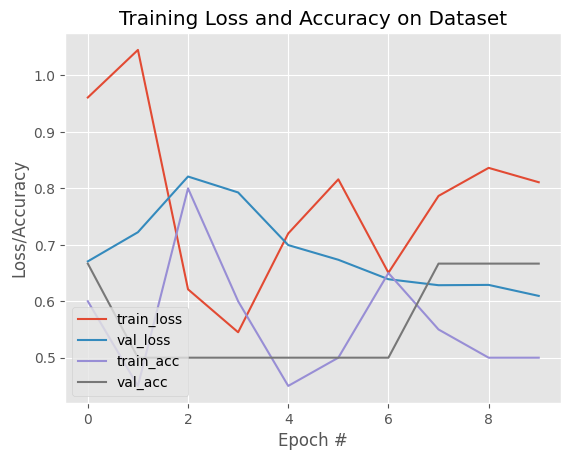

In [21]:
plot_history(history)

Based on the plot above, it looks like our model stopped learning after 7 epochs. You can tell this by looking at the decline in val_loss from epochs 0-7. 

## Try a model with less dropout, same learning rate: 

In [22]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.3))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.3))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [23]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [28]:
# Create fresh optimizer instance
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

# Compile model with new optimizer
new_model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy']
)

# Train the model
history = new_model.fit(
    train_gen,
    validation_data=(testX, testY),
    epochs=10,
    verbose=1
)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 7s/step - binary_accuracy: 0.4497 - loss: 0.8206 - val_binary_accuracy: 0.5000 - val_loss: 0.6810
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 26s 9s/step - binary_accuracy: 0.5000 - loss: 0.7211 - val_binary_accuracy: 0.3333 - val_loss: 0.6563
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 31s 9s/step - binary_accuracy: 0.7361 - loss: 0.5954 - val_binary_accuracy: 0.8333 - val_loss: 0.6223
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 27s 9s/step - binary_accuracy: 0.7740 - loss: 0.5045 - val_binary_accuracy: 0.6667 - val_loss: 0.6337
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - binary_accuracy: 0.6583 - loss: 0.6407 - val_binary_accuracy: 0.8333 - val_loss: 0.5529
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 8s/step - binary_accuracy: 0.8795 - loss: 0.4358 - val_binary_accuracy: 0.5000 - val_loss: 0.5407
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step - binary_accuracy: 0.8745 - loss: 0.3945 - val_binary_accuracy: 0.6667 - val_loss: 0.5507
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━

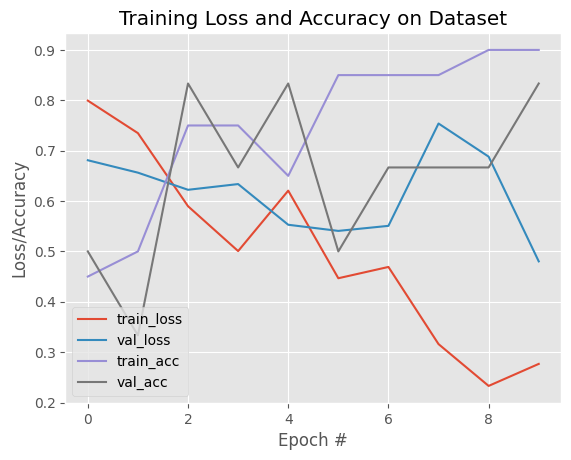

In [29]:
plot_history(history)

With less dropout, it looks like the model got worse since the train_loss dropped dramatically but the val_loss increased.

## Finally, try a model with the same amount of dropout as you initially had, but a slower learning rate: 

In [30]:
new_model = Sequential()

# Add the convolutional part of the VGG16 model from above.
new_model.add(vgg_model)

# Flatten the output of the VGG16 model because it is from a
# convolutional layer.
new_model.add(Flatten())

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(1024, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(512, activation='relu'))

# Add a dropout-layer which may prevent overfitting and
# improve generalization ability to unseen data e.g. the test-set.
new_model.add(Dropout(0.5))

# Add a dense (aka. fully-connected) layer.
# This is for combining features that the VGG16 model has
# recognized in the image.
new_model.add(Dense(256, activation='relu'))

# Add a dense (aka. fully-connected) layer.
# Change the activation function to sigmoid 
# so output of the last layer is in the range of [0,1] 
new_model.add(Dense(1, activation='sigmoid'))

In [32]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(learning_rate=1e-6)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [33]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [35]:
history = new_model.fit(train_gen, 
                                  validation_data = (testX, testY), 
                                  epochs = 10)

Epoch 1/10


/Users/anup/anup_prompt_venv/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 8s/step - binary_accuracy: 0.5341 - loss: 0.7100 - val_binary_accuracy: 0.5000 - val_loss: 0.7812
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 6s/step - binary_accuracy: 0.6583 - loss: 0.6610 - val_binary_accuracy: 0.5000 - val_loss: 0.7798
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 23s 7s/step - binary_accuracy: 0.4750 - loss: 0.8659 - val_binary_accuracy: 0.5000 - val_loss: 0.7783
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 42s 15s/step - binary_accuracy: 0.6194 - loss: 0.8331 - val_binary_accuracy: 0.5000 - val_loss: 0.7767
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - binary_accuracy: 0.6833 - loss: 0.6093 - val_binary_accuracy: 0.5000 - val_loss: 0.7758
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - binary_accuracy: 0.3237 - loss: 0.8827 - val_binary_accuracy: 0.5000 - val_loss: 0.7748
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 9s/step - binary_accuracy: 0.5114 - loss: 0.8538 - val_binary_accuracy: 0.5000 - val_loss: 0.7746
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 18s 8s/s

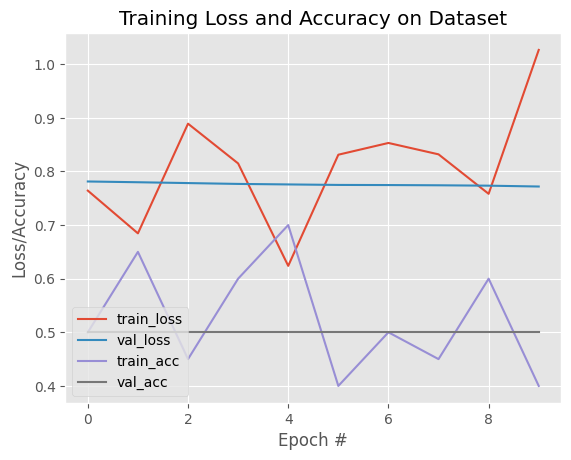

In [36]:
plot_history(history)

The performance with this architecture and parameters is pretty unstable, and also isn't learning based on the flat val_loss curve. We see, however, that between epoch 3 and 8 the train_loss goes down, which indicates that while the model was learning _something,_ it was essentially just learning to overfit on the training data. 

This notebook demonstrates a complete deep learning workflow for medical image classification using transfer learning,
specifically applying a VGG16 convolutional neural network pre-trained on ImageNet to classify mammogram images as "dense" or "fatty."

The process includes loading and preprocessing data with augmentation for the training set and rescaling for validation,
building a transfer learning model by freezing most of the VGG16 layers and adding custom dense and dropout layers,
compiling and training the model with appropriate loss and metrics, and visualizing training history to evaluate performance and experiment with hyperparameters like dropout and learning rate.

This approach exemplifies best practices in healthcare machine learning, leveraging transfer learning to address limited labeled data, using data augmentation for robustness, and emphasizing careful validation to avoid overfitting, ultimately aiming to support clinical decision-making with reliable AI models.
